# Figure 1 creation

In [1]:
import h5py
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patch
import scipy.ndimage as ndimg
import scipy.signal as signal 
import scipy.stats as stat
from alphashape import alphashape
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

In [2]:
import sys
import os
functions_folder = os.path.abspath('C:/Users/mmill/Documents/STAGE M1/Functions')
if functions_folder not in sys.path:
    sys.path.append(functions_folder)
from Detection_functions import MCDA

In [3]:
condition='anesthesia' #between anesthesia and awake
session='evokedD' #between evokedU, evokedD and spontaneous

In [4]:
original_data_directory=r'C:/Users/mmill/Documents/STAGE M1/DATA/'

In [5]:
if condition=='awake':
    if session=='evoked':
        bks_evoked_path = original_data_directory+'gaussian_pos4_ziggy_210908.npy'
        Data = np.load(bks_evoked_path)
    elif session=='spontaneous':
        bks_blank_path = original_data_directory+'blank_ziggy_210908.npy'
        Data = np.load(bks_blank_path)
    mean = np.nanmean(Data)
    nan_loc = np.isnan(Data)
    Data[nan_loc] = mean
    N_trials, Nt, Nx, Ny = Data.shape
    fs = 100 #Hz
    pixel_spacing = 0.045 #mm
    line=np.array([[ 49, 409],[ 87, 131]])
    circle =[[219, 187], 199]
    Y, X = np.ogrid[:Nx, :Ny]
    mask =  ((X - circle[0][0]) ** 2 + (Y - circle[0][1]) ** 2) <= circle[1] ** 2

if condition=='anesthesia':
    if session=='evokedD':
        anesth_evokedD_path = original_data_directory+'signal_240306_gaussianD.mat'
        file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedD),2, axes=(2,3))
    elif session=='evokedU':
        anesth_evokedU_path = original_data_directory+'signal_240306_gaussianU.mat'
        file_anesth_evokedU = h5py.File(anesth_evokedU_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedU),2, axes=(2,3))
    elif session=='spontaneous':
        anesth_blank_path = original_data_directory+'signal_240306_blank.mat' #change it to adapt to your directories
        file_anesth_blank = h5py.File(anesth_blank_path)['signal']
        Data = np.rot90(np.array(file_anesth_blank), 2,axes=(2,3))
    N_trials, Nt, Nx, Ny = Data.shape
    fs=110 #Hz
    pixel_spacing = 0.064 #mm
    line=np.array([[251,   5],[ 90, 118]])
    circle=[[145, 125], 140]
    Y, X = np.ogrid[:Nx, :Ny]
    mask =  ((X - circle[0][0]) ** 2 + (Y - circle[0][1]) ** 2) <= circle[1] ** 2

In [6]:
trial_number=16
test_trial=Data[trial_number]

In [7]:
butt_filt = signal.butter(N=4, Wn=30, btype='lowpass', fs=fs, output='sos')
trial_filt=signal.sosfiltfilt(butt_filt, test_trial, axis=0)

In [8]:
start=118
end=128

In [9]:
Trial=np.copy(trial_filt[start:end]*mask)

## Raw and smoothed data

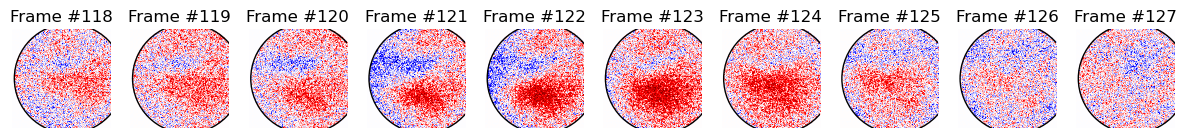

In [39]:
Norm1 = colors.Normalize(vmax=1.2, vmin=-1.2)
fig1, axs = plt.subplots(1,end-start,figsize=((end-start)*1.5,1.75))#, gridspec_kw={'width_ratios': [1.4] * (end-start) + [0.07]})
for index,trial in enumerate(Trial):
    unsmoothed=axs[index].imshow(trial, cmap='seismic', norm=Norm1)
    axs[index].set_title(f'Frame #{index+start}')
    axs[index].axis('off')
    axs[index].add_patch(patch.Circle(circle[0], circle[1], color='k', fill=False))
    axs[index].set_aspect('equal')
#cbar1=fig1.colorbar(unsmoothed, cax=axs[-1])
#cbar1.set_label(r'$\frac{ \Delta F}{F}$', fontsize=15, rotation=0, labelpad=10)

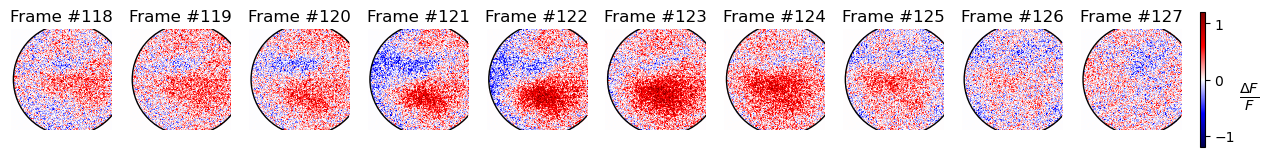

In [41]:
Norm1 = colors.Normalize(vmax=1.2, vmin=-1.2)
fig1z, axs = plt.subplots(1,end-start+1,figsize=((end-start)*1.5+0.4,1.75), gridspec_kw={'width_ratios': [1] * (end-start) + [0.05]})
for index,trial in enumerate(Trial):
    unsmoothed=axs[index].imshow(trial, cmap='seismic', norm=Norm1)
    axs[index].set_title(f'Frame #{index+start}')
    axs[index].axis('off')
    axs[index].add_patch(patch.Circle(circle[0], circle[1], color='k', fill=False))
    axs[index].set_aspect('equal')
cbar1=fig1z.colorbar(unsmoothed, cax=axs[-1])
cbar1.set_label(r'$\frac{ \Delta F}{F}$', fontsize=15, rotation=0, labelpad=10)

## Threshold

In [13]:
thresh_value=np.percentile(Trial, 99)
Trial_th = Trial - thresh_value
Trial_th[Trial_th<0]=0
T,Y,X = np.where(Trial_th>0)
list_points=[np.vstack((X[T==t],Y[T==t])).T for t in range(end-start)]

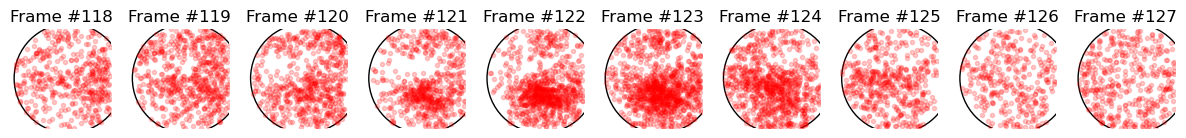

In [42]:
fig2, axs = plt.subplots(1,end-start,figsize=((end-start)*1.5,1.75))
for j in range(end-start):
    axs[j].set_aspect('equal')
    axs[j].set_xlim(0,Ny)
    axs[j].set_ylim(0,Nx)
    axs[j].add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
    axs[j].plot(list_points[j][:,0],list_points[j][:,1],'r.', alpha=.2)
    axs[j].invert_yaxis()
    axs[j].set_title(f'Frame #{j+start}')
    axs[j].axis('off')


## Clustering

In [15]:
eps=19
min_samples=32

In [16]:
Clusters=[]
for points in list_points:
    clust_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labs_dbscan = clust_dbscan.fit_predict(points)
    print(f'{labs_dbscan.max()+1} clusters detected')
    clust_dbscan_points = [points[labs_dbscan == label] for label in np.unique(labs_dbscan) if label != -1]
    list_polyg = [alphashape(clust_dbscan_points[j],0.1) for j in range(labs_dbscan.max()+1)]
    Clusters.append(list_polyg)

0 clusters detected
1 clusters detected
1 clusters detected
1 clusters detected
1 clusters detected
2 clusters detected
1 clusters detected
1 clusters detected
0 clusters detected
0 clusters detected


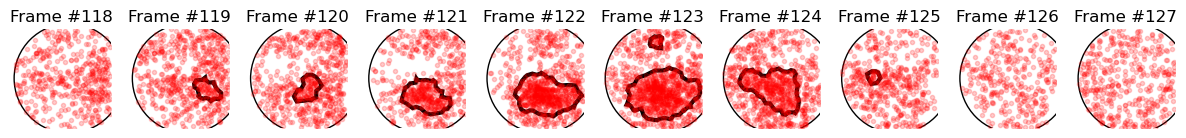

In [43]:
fig3, axs = plt.subplots(1,end-start,figsize=((end-start)*1.5,1.75))
for j in range(end-start):
    axs[j].set_aspect('equal')
    axs[j].set_xlim(0,Ny)
    axs[j].set_ylim(0,Nx)
    axs[j].add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
    axs[j].plot(list_points[j][:,0],list_points[j][:,1],'r.', alpha=.2)
    axs[j].invert_yaxis()
    axs[j].set_title(f'Frame #{j+start}')
    axs[j].axis('off')
    for i,polyg in enumerate(Clusters[j]):
        position=np.vstack(polyg.exterior.xy).T
        axs[j].add_patch(patch.Polygon(position,edgecolor='k',facecolor='none', closed=True,  linewidth=3))

## Overlap between pairwise clusters

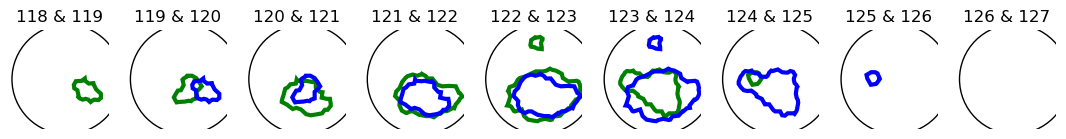

In [51]:
fig4, axs = plt.subplots(1,end-start-1,figsize=((end-start-1)*1.5,1.75))
for j in range(1,end-start):
    axs[j-1].set_aspect('equal')
    axs[j-1].set_xlim(0,Ny)
    axs[j-1].set_ylim(0,Nx)
    axs[j-1].add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
    axs[j-1].plot(list_points[j-1][:,0],list_points[j-1][:,1],'r.', alpha=.001)
    axs[j-1].invert_yaxis()
    axs[j-1].set_title(f'{j+start-1} & {j+start}')
    axs[j-1].axis('off')
    for polyg1 in Clusters[j]:
        position1=np.vstack(polyg1.exterior.xy).T
        axs[j-1].add_patch(patch.Polygon(position1,edgecolor='g',facecolor='none', closed=True,  linewidth=3))
    for polyg2 in Clusters[j-1]:
        position2=np.vstack(polyg2.exterior.xy).T
        axs[j-1].add_patch(patch.Polygon(position2,edgecolor='b',facecolor='none', closed=True,  linewidth=3))

## Detection plot

end: only the clusters implied in a real moving cluster

In [19]:
mcda = MCDA(Trial_th, eps, min_samples, 0.4)

In [20]:
len(mcda)

1

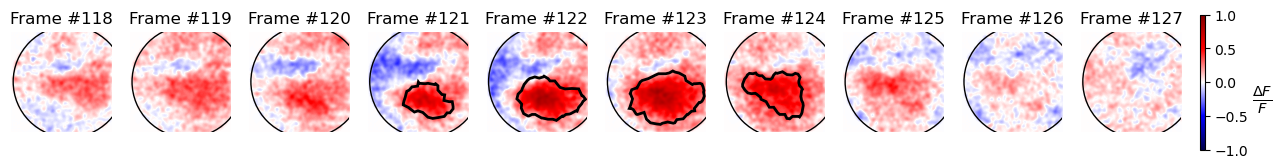

In [49]:
Norm = colors.Normalize(vmax=1, vmin=-1)
fig5, axs = plt.subplots(1,end-start+1,figsize=((end-start)*1.5+0.4,1.75), gridspec_kw={'width_ratios': [1] * (end-start) + [0.05]})
for index,trial in enumerate(Trial):
    axs[index].set_aspect('equal')
    axs[index].set_xlim(0,Ny)
    axs[index].set_ylim(0,Nx)
    axs[index].add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
    axs[index].set_title(f'Frame #{index+start}')
    smoothed2=axs[index].imshow(ndimg.gaussian_filter(trial, sigma=4, mode='constant'), cmap='seismic', norm=Norm)
    axs[index].axis('off')
    axs[index].invert_yaxis()
for mc in mcda: 
    for i,j in enumerate(mc['trace']):
        x,y = mc['alpha shapes'][i].exterior.xy
        position=np.vstack((y,x)).T
        mpl_poly = patch.Polygon(position, closed=True,facecolor='None',edgecolor='k',linewidth=2)
        axs[j].add_patch(mpl_poly)
        #axs[start+j].legend(fontsize='xx-small')
cbar5=fig5.colorbar(smoothed2, cax=axs[-1])
cbar5.set_label(r'$\frac{ \Delta F}{F}$', fontsize=15, rotation=0, labelpad=10)

## Save

In [22]:
savefigure = True

In [52]:
if savefigure:    
    fig1.savefig('A')
    fig1z.savefig('rr')
    fig2.savefig('B')
    fig3.savefig('C')
    fig4.savefig('D')
    fig5.savefig('E')